# Exploring MyAnimeList Genres

### Intro

MyAnimeList is a website where, among other things, users catalog anime and their anime-watching history. The rich combination of media and user data makes exploring the relationship between the two an appealing prospect. 

### Data Collection

I will be working off of [a MAL dataset uploaded to Kaggle in 2018 by user Azathoth.](https://www.kaggle.com/azathoth42/myanimelist)  Download the 'filtered' versions of these files to the folder containing this file.  The filtered versions restrict data to that of users who have filled out their profile information, as well as excluding a few bogus users.  A small number of anime titles have also been filtered out for reasons unstated by the source.  We'll import the data and necessary libraries and take a quick look at the basics of each dataset.

In [1]:
import math
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%%time
users = pd.read_csv('users_filtered.csv')
titles = pd.read_csv('anime_filtered.csv')
animelists = pd.read_csv('animelists_filtered.csv')

Wall time: 1min 49s


In [3]:
users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0


In [4]:
titles.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme'],
      dtype='object')

In [5]:
animelists.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,1362307973,NaN
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,1355480701,NaN
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,1254296345,NaN
3,bskai,21,75,0000-00-00,0000-00-00,8,1,0.0,0,1276637483,NaN
4,Slimak,21,834,0000-00-00,0000-00-00,10,1,0.0,0,1525176321,NaN


### Clean up, clean up

Date columns need to be converted to the appropriate types, some lists need to be re-represented, and there are dictionaries to evaluate.  Two users had invalid birthdates like '1337' which were coerced to nulls.  Not all of these columns will be used for this analysis, but they may be useful another time.  Finally, we're going to restrict the analysis to a random sample of 1500 anime with genre tags, for the sake of my poor computer.  MAL includes other media like movies, OVAs, and music in their dataset; for now we'll only look at TV shows.

In [6]:
%%time
# Turn date columns into dates
users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce').dt.date
users['join_date'] = pd.to_datetime(users['join_date']).dt.date
users['last_online_date'] = pd.to_datetime(users['last_online']).dt.date

# Turn unique list columns into 
titles['genre_list'] = titles['genre'].str.split(', ')
titles['producer_list'] = titles['producer'].str.split(', ')
titles['licensor_list'] = titles['licensor'].str.split(', ')
titles['studio_list'] = titles['studio'].str.split(', ')

# Turn dict columns into dicts
titles['aired_dict'] = titles['aired'].apply(eval)
titles['started_airing'] = [i['from'] for i in titles['aired_dict']]
titles['finished_airing'] = [i['to'] for i in titles['aired_dict']]
titles['related_dict'] = titles['related'].apply(eval)

# Remove titles without a genre and choose the 1500 most popular TV titles.  Make the genre lists into sets.
titles = titles[(pd.notnull(titles['genre_list'])) & (titles['popularity'] > 0) & (titles['type'] == 'TV')]
#sampled_titles = titles.sort_values(by=['popularity'],ascending=True).iloc[:1500,:].reset_index()
sampled_titles = titles.sample(n=1500,random_state=1).reset_index()
sampled_titles['genre_list'] = [set(i) for i in sampled_titles['genre_list']]

# Apply the top 1500 TV titles filter to the animelists table.  Converting the list to set format keeps this reasonably fast.
top_anime = set(sampled_titles['anime_id'])
top_animelists = animelists[[(i in top_anime) for i in animelists['anime_id']]]
top_animelists = top_animelists[[i in [1,2,6] for i in top_animelists['my_status']]]

Wall time: 22.6 s


### Pairwise Genre Similarity - shared genres

Let's take a look at the genre tags in the dataset and a sampling of individual shows' genres:

In [7]:
genre_list = set()

for genres in titles['genre_list']:
    genre_list.update(genres)

# Create the binary columns - 1 if genre attaches to title, 0 otherwise.
for genre in genre_list:
    titles[genre] = [(1 if genre in i else 0) for i in titles['genre_list']]
titles.loc[:,'Martial Arts':].sum(axis=0).sort_values(ascending=False)

Fantasy         873
Historical      316
Harem           188
Demons          120
Martial Arts    106
Vampire          55
Thriller         36
dtype: int64

In [8]:
sampled_titles[['anime_id','genre_list']].head(10)

,anime_id,genre_list
0,12771,"{Slice of Life, Comedy}"
1,1391,"{Adventure, Sci-Fi, Sports, Shounen}"
2,925,"{Adventure, Sci-Fi, Mecha, Shounen}"
3,19839,"{Game, Historical}"
4,35078,"{Slice of Life, Comedy, Shounen}"
5,22145,"{Comedy, Shounen, Historical, Supernatural, De..."
6,9955,"{Kids, Slice of Life}"
7,1816,"{Kids, Comedy, Shounen, Adventure, Sci-Fi, Mecha}"
8,17267,"{Super Power, Comedy, Mystery}"
9,3841,"{Slice of Life, Comedy}"


A first cut at assessing the similarity between two shows is simply to count the number of shared genres, that is, the intersection of the two shows' genre sets.  Let's go ahead and implement that.

In [9]:
# Build the shared-genre-count edge list
ID_MULTIPLIER = 10 ** 6
def get_id(anime_1, anime_2):
    return anime_1 * ID_MULTIPLIER + anime_2

sampled_titles.sort_values(by='anime_id',ascending=True)

edges = dict()

for i in range(len(sampled_titles)):
    anime_1 = sampled_titles['anime_id'][i]
    genres_1 = sampled_titles['genre_list'][i]
    for j in range(len(sampled_titles)):
        if i == j:
            continue
        anime_2 = sampled_titles['anime_id'][j]
        genres_2 = sampled_titles['genre_list'][j]
        genre_count = len(genres_1.intersection(genres_2))
        edges[get_id(anime_1, anime_2)] = {'source': anime_1, 'target': anime_2, 'shared_genres': genre_count}

### Show Similarity - # of viewers who have watched both shows

Another way to assess similarity of two shows is to see how many people have watched both of them.  We can implement this similarly to the above, by gathering the set of people who have watched each show and taking every pairwise intersection.

In [10]:
# Build the sets of watchers and plan-to-watchers for each anime
watchers_by_id = top_animelists[['username','anime_id','my_status']].groupby(
    ['anime_id','my_status']).agg(lambda x: set(x)).unstack()

watchers_by_id.columns = [1,2,6]
for col in watchers_by_id.columns:
    watchers_by_id.loc[watchers_by_id[col].isna(),col] = set()
watchers_by_id['watch'] = [watchers_by_id[1][i].union(watchers_by_id[2][i]) for i in watchers_by_id.index]
watchers_by_id = watchers_by_id.drop(columns=[1,2]).rename(columns={6:'plan_to_watch'})
watchers_by_id.head()

,plan_to_watch,watch
anime_id,,
15,"{Kiraak-Kun, SouDaaaaaa, barric, Sealuck, Zayn...","{Zer00, chiori_lu, HungLikeaZombie, corel, Shi..."
17,"{Ataio, MistXGun, Salvahkiin, Yenne, Stuv12345...","{Doomhammer, Swardi1, Sora_Namari, Shuuya_Stri..."
20,"{treehugger1995, Sealuck, Sara_Elric, GuillemP...","{Saber120, Sepris, escie, envus, yun1105, nero..."
22,"{muddysheep2006, kuroyiri, Zer00, banglaCM, Ty...","{JinLost, SuzuyaJuuzo, janelleski, corel, Shiz..."
28,"{Kiraak-Kun, shrimple, Dilvish, ramuramu, Guil...","{SuzuyaJuuzo, Reanu, chiori_lu, Liloute, Zoso0..."


The next cell is the slowest in the notebook.  5-6 minutes for my computer with a random sample of titles, 20+ minutes for the 1500 most popular titles.

In [11]:
%%time
# Build the edge list of # of shared watchers and plan-to-watchers
for i in watchers_by_id.index:
    watchers_1 = watchers_by_id.loc[i,'watch']
    for j in watchers_by_id.index:
        if i == j:
            continue
        edges[get_id(i, j)]['watch_edge'] = len(watchers_1.intersection(watchers_by_id.loc[j,'watch']))
        edges[get_id(i, j)]['plan_to_watch_edge'] = len(watchers_1.intersection(watchers_by_id.loc[j,'plan_to_watch']))

Wall time: 5min 16s


### Pairwise Genre Similarity - Term Frequency-Inverse Document Frequency

Intuitively, one way to improve on shared genre count as a measure of genre similarity is to prioritize rare genres over common ones.  If two shows share a rare genre, they may be more likely to be similar than if they share a common genre.  The algorithm associated with this reasoning is called [Term Frequency-Inverse Document Frequency](https://towardsdatascience.com/the-4-recommendation-engines-that-can-predict-your-movie-tastes-109dc4e10c52).

First, we weight the genres by the inverse log of their overall frequency among all titles in the sample.  Then, we turn the genre lists for each title into genre vectors in a 40-dimensional space where the vector's value in each genre dimension is either the weight of the genre (if that genre was on the list) or 0 (if not).  Finally, we calculate the cosine similarity between each vector to obtain a similarity score.

In [ ]:
# Creating binary encoding of genres for cosine similarity work.

# Gather all the genres
genre_list = set()

for genres in sampled_titles['genre_list']:
    genre_list.update(genres)

# Create the binary columns - 1 if genre attaches to title, 0 otherwise.
for genre in genre_list:
    sampled_titles[genre] = [(1 if genre in i else 0) for i in sampled_titles['genre_list']]
genre_log_inv_freq = np.log(1500/sampled_titles.iloc[:,-40:].sum(axis=0))

# Apply frequency to genre columns to create weight array
genre_weights = sampled_titles.iloc[:,-40:].multiply(genre_log_inv_freq).values

In [30]:
# Apply cosine similarity to get genre similarity between titles.
edge_weights = cosine_similarity(genre_weights, genre_weights)
edge_weights = pd.DataFrame(edge_weights, index=sampled_titles['anime_id'].values, columns=sampled_titles['anime_id'].values)

# Modifying stacking technique from
# https://stackoverflow.com/questions/48218455/how-to-create-an-edge-list-dataframe-from-a-adjacency-matrix-in-python
for i in edge_weights.index:
    edge_weights.loc[i,i] = np.nan
edge_weights = edge_weights.stack().reset_index().rename(
    columns={'level_0':'source','level_1':'target',0:'tf_idf_weights'}).set_index(['source','target'])
edge_weights.head()

tf_idf_weights
source target                
12771  1391          0.000000
       925           0.000000
       19839         0.000000
       35078         0.749094
       22145         0.049737

### Drawing a Genre Map

We're going to draw the map based on the TF-IDF weights.  We'll use networkx to keep track of the graph, and in particular the spring_layout method, which uses the [force-directed graph](https://toucantoco.com/en/glossary/force-directed-graph.html) algorithm, to position the nodes based on edge weights.  Node size will be determined by the 'members' attribute, which is simply the number of MyAnimeList members that have added the show to their watch history.  The absolute positions of the nodes doesn't mean anything - this is purely a relational graph.

In [31]:
# Consolidate the edge attribute list
edges_df = pd.DataFrame.from_dict(edges, orient="index").join(edge_weights,on=['source','target'],how='left')
edges_df.head()

,source,target,shared_genres,watch_edge,plan_to_watch_edge,tf_idf_weights
15000017,15,17,3,849,137,0.821458
15000020,15,20,3,5285,35,0.264607
15000022,15,22,4,2616,276,0.878919
15000028,15,28,2,1542,265,0.533991
15000033,15,33,1,2354,405,0.055298


In [32]:
# Create the graph from the edge list and title list
G = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr=list(edges_df.columns[2:]))
G.add_nodes_from([[sampled_titles['anime_id'][i], sampled_titles.iloc[i,2:].to_dict()] for i in range(len(sampled_titles))])

In [33]:
# Create the force-directed graph with networkx's spring layout function
pos = nx.drawing.layout.spring_layout(G, weight='tf_idf_weights', seed=1)

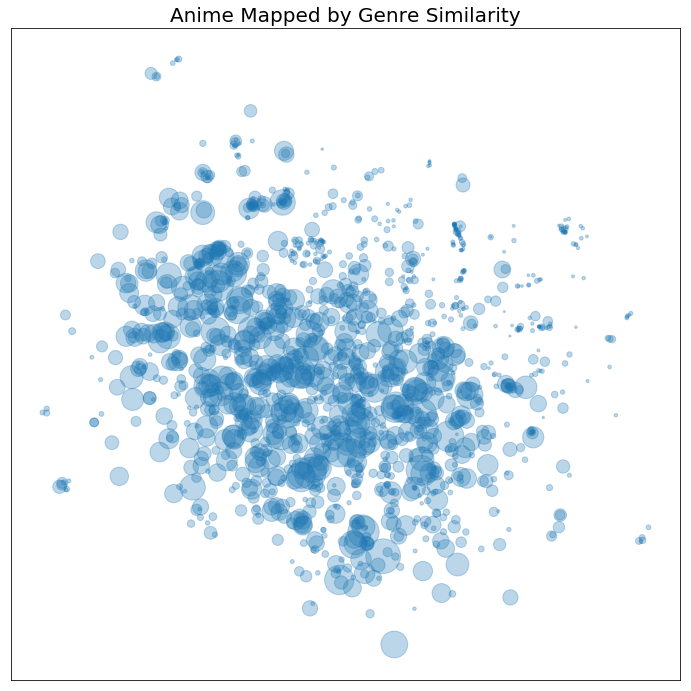

In [34]:
# Draw the graph
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos, nodelist = [i for i in sampled_titles['anime_id']], edgelist = [],
                 alpha=0.3, node_size=np.sqrt(sampled_titles['members']), with_labels=False,
                 label='Other Shows')
plt.title('Anime Mapped by Genre Similarity',fontsize=20)
plt.savefig('Visualizations/anime_by_genre.png', bbox_inches='tight')

### An Example Genre

To move beyond a collection of differently-sized blobs, we can color in some genres.  In particular, we'll look at romance shows targeted at various demographics.  We can see that nodes of a given genre do cluster within the network, and that sub-genres do cluster within the genre to varying degrees.  This offers some confidence that the map contains useful information.

Wall time: 452 ms


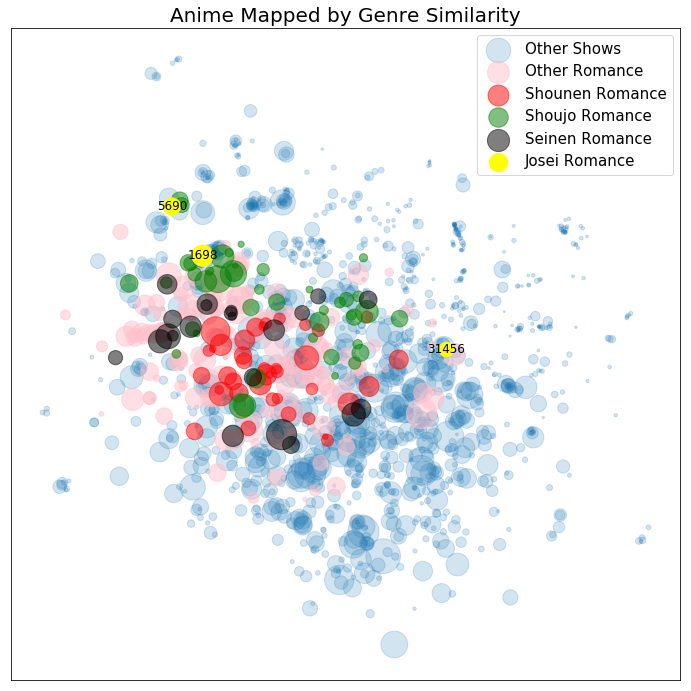

In [36]:
%%time
plt.figure(figsize=(12,12))
shounen_romance = sampled_titles[(sampled_titles['Shounen'] == 1) & (sampled_titles['Romance'] == 1)]
seinen_romance = sampled_titles[(sampled_titles['Seinen'] == 1) & (sampled_titles['Romance'] == 1)]
shoujo_romance = sampled_titles[(sampled_titles['Shoujo'] == 1) & (sampled_titles['Romance'] == 1)]
josei_romance = sampled_titles[(sampled_titles['Josei'] == 1) & (sampled_titles['Romance'] == 1)]
other_romance = sampled_titles[(sampled_titles['Romance']== 1) & (sampled_titles['Shounen']==0)
                              & (sampled_titles['Shoujo'] == 0) & (sampled_titles['Josei'] == 0)
                              & (sampled_titles['Seinen'] == 0)]
non_romance = sampled_titles[sampled_titles['Romance'] == 0]

nx.draw_networkx(G, pos, nodelist = [i for i in non_romance['anime_id']], edgelist = [],
                 alpha=0.2, node_size=np.sqrt(non_romance['members']), with_labels=False,
                 label='Other Shows')
nx.draw_networkx(G, pos, nodelist = [i for i in other_romance['anime_id']], edgelist = [],
                 alpha=0.5, node_size=np.sqrt(other_romance['members']), node_color='pink', with_labels=False,
                 label='Other Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in shounen_romance['anime_id']], edgelist = [],
                 alpha=0.5, node_size=np.sqrt(shounen_romance['members']), node_color='red', with_labels=False,
                 label='Shounen Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in shoujo_romance['anime_id']],edgelist = [],
                 alpha=0.5, node_size=np.sqrt(shoujo_romance['members']), node_color='green', with_labels=False,
                label='Shoujo Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in seinen_romance['anime_id']], edgelist=[],
                 alpha=0.5, node_size=np.sqrt(seinen_romance['members']), node_color='black', with_labels=False,
                label='Seinen Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in josei_romance['anime_id']], edgelist=[],
                 alpha=1, node_size=np.sqrt(josei_romance['members']), node_color='yellow', with_labels=False,
                label='Josei Romance')
nx.draw_networkx_labels(G, pos,
                        labels={josei_romance['anime_id'][i]:josei_romance['anime_id'][i] for i in josei_romance.index})

plt.title('Anime Mapped by Genre Similarity',fontsize=20)
plt.legend(fontsize=15)
plt.savefig('Visualizations/romance_genres.png', bbox_inches='tight')

In [37]:
pd.DataFrame([['Shounen (Young Men)', len(shounen_romance)],
 ['Shoujo (Young Women)',len(shoujo_romance)],
 ['Seinen (Adult Men)',len(seinen_romance)],
 ['Josei (Adult Women)',len(josei_romance)],
 ['Other',len(other_romance)]])

,0,1
0,Shounen (Young Men),39
1,Shoujo (Young Women),43
2,Seinen (Adult Men),22
3,Josei (Adult Women),3
4,Other,159


### Assessing the Graph - Most Similar Titles

It's difficult to assess whether a graph like this is 'accurate'.  However, there are some rudimentary measures that can be looked at.  We'll start by drawing edges between each title and the title it shares the highest similarity with.  We can see that there's a fair amount of tight clustering between most-similar titles, but also a number of titles that cross large gaps or even stretch halfway across the network to reach their most-similar counterparts.  Not entirely what was hoped for, but certainly better than nothing.

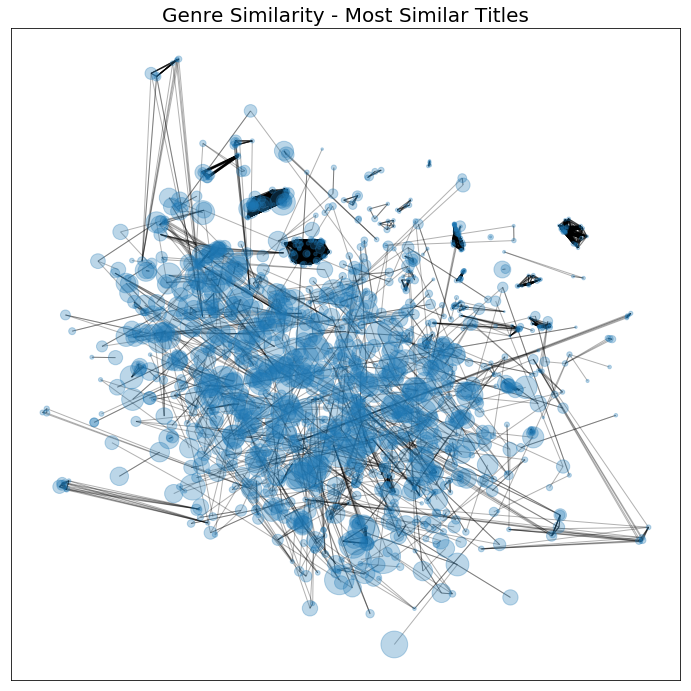

In [38]:
most_similar_titles = edges_df[edges_df.groupby(['source'])['tf_idf_weights'].transform(max) == edges_df['tf_idf_weights']]
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos, nodelist = [i for i in sampled_titles['anime_id']],
                 edgelist = [[most_similar_titles['source'][i],most_similar_titles['target'][i]]
                              for i in most_similar_titles.index],
                 alpha=0.3, node_size=np.sqrt(sampled_titles['members']), with_labels=False,
                 label='Other Shows')
plt.title('Genre Similarity - Most Similar Titles',fontsize=20)
plt.savefig('Visualizations/most_similar_titles.png', bbox_inches='tight')

### Assessing the Graph - Cosine Similarity vs. Distance

Apart from most-similar nodes, we would also expect that nodes with higher cosine similarity tend to cluster closer together than nodes with lower cosine similarity in general.  Visual inspection seems to confirm this - however, I hesitate to fit a line to this graph because the distribution of cosine similarities is so uneven.  And the apparent trend is only modestly downward.

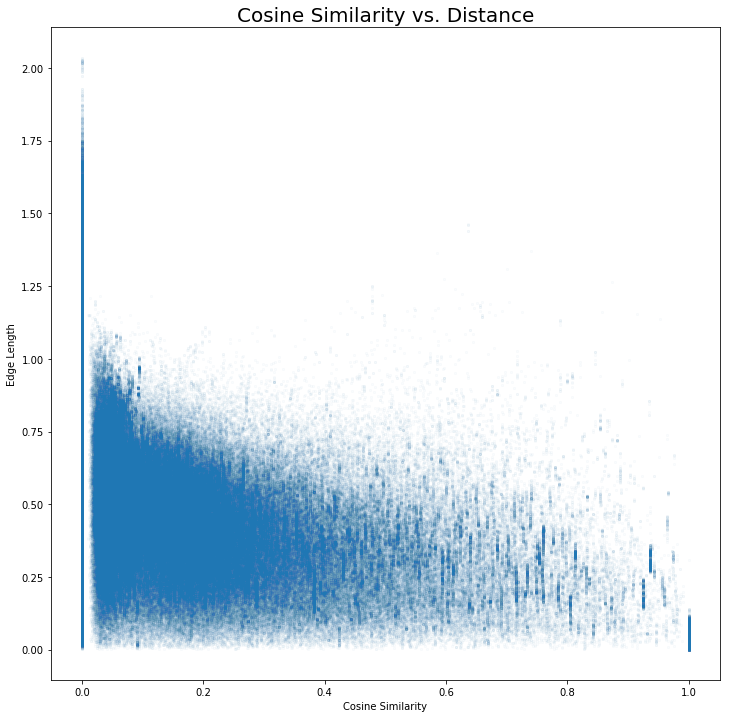

In [39]:
weights = nx.get_edge_attributes(G,'tf_idf_weights')

# Edge lengths courtesy of
# https://stackoverflow.com/questions/26312780/distance-between-nodes-using-python-networkx
lengths={}
for edge in G.edges():
    startnode=edge[0] 
    endnode=edge[1]
    lengths[edge]=math.sqrt(((pos[endnode][1]-pos[startnode][1])**2)+
                                      ((pos[endnode][0]-pos[startnode][0])**2))

weight_list = []
length_list = []
for i in weights.keys():
    weight_list.append(weights[i])
    length_list.append(lengths[i])

plt.figure(figsize=(12,12))
plt.scatter(weight_list, length_list, alpha=0.02, s=5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Edge Length')
plt.title('Cosine Similarity vs. Distance', fontsize=20)
plt.savefig('Visualizations/weight_distance_scatter.png', bbox_inches='tight')

### Assessing the Graph - Robustness

One last thing we can do to test the graph is to see how stable it is when the parameters change.  For now, the only parameter I will test is the initial random node layout.  In the future I could also repeat the algorithm with another sample, but I'll skip that for now.  The network drawn by force-directed graphing with the new seed appears to be very nearly a rotational transformation of the original graph, suggesting that this network layout is fairly stable.

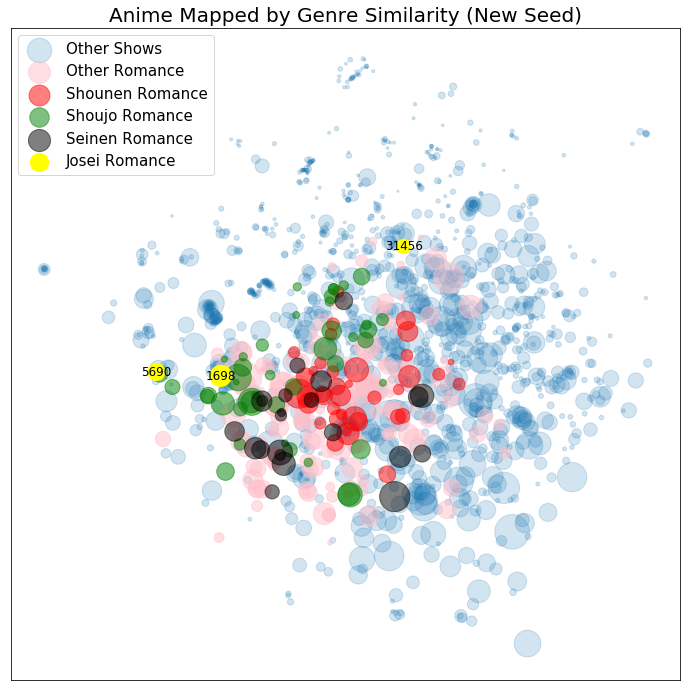

In [40]:
pos = nx.drawing.layout.spring_layout(G, weight='tf_idf_weights', seed=2)

plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos, nodelist = [i for i in non_romance['anime_id']], edgelist = [],
                 alpha=0.2, node_size=np.sqrt(non_romance['members']), with_labels=False,
                 label='Other Shows')
nx.draw_networkx(G, pos, nodelist = [i for i in other_romance['anime_id']], edgelist = [],
                 alpha=0.5, node_size=np.sqrt(other_romance['members']), node_color='pink', with_labels=False,
                 label='Other Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in shounen_romance['anime_id']], edgelist = [],
                 alpha=0.5, node_size=np.sqrt(shounen_romance['members']), node_color='red', with_labels=False,
                 label='Shounen Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in shoujo_romance['anime_id']],edgelist = [],
                 alpha=0.5, node_size=np.sqrt(shoujo_romance['members']), node_color='green', with_labels=False,
                label='Shoujo Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in seinen_romance['anime_id']], edgelist=[],
                 alpha=0.5, node_size=np.sqrt(seinen_romance['members']), node_color='black', with_labels=False,
                label='Seinen Romance')
nx.draw_networkx(G, pos, nodelist = [i for i in josei_romance['anime_id']], edgelist=[],
                 alpha=1, node_size=np.sqrt(josei_romance['members']), node_color='yellow', with_labels=False,
                label='Josei Romance')
nx.draw_networkx_labels(G, pos,
                        labels={josei_romance['anime_id'][i]:josei_romance['anime_id'][i] for i in josei_romance.index})

plt.title('Anime Mapped by Genre Similarity (New Seed)',fontsize=20)
plt.legend(fontsize=15)
plt.savefig('Visualizations/romance_genres_seed2.png', bbox_inches='tight')